# Gradient Boosting

### Geral

Gradient Boosting é uma técnica de ensemble com alto poder preditivo e se baseia na noção da utilização de múltiplos estimadores - um conjunto de "weak leaners" (modelo minimamente superior a "random guessing", apenas uma  pequena correlação com a variável resposta) para se criar ao final um "strong learner", ou seja, com  alta capacidade de predição.  
Cada arvore corrige os erros dos meus predecessores (como o MSE no caso da regressão) - sendo que para tal a se define uma medida de custo, em que normalmente se utiliza os resíduos (diferença entre valor real e resposta do modelo). Assim, caminha-se para uma solução que melhor representa os dados de maneira semelhante ao método do gradiente descendente quando minimizamos os coefiecientes numa regressão linear, em que cada estimador representa uma diminuição no custo.  Assim, gradient boosting utiliza o método do gradiente descendente para minimizar o custo.

Ao final, cada arvore esta sujeita a taxa de aprendizagem (comum e constante para todas as ávores) que faz com que passos progressivos são dados em direção ao ponto mínimo de custo (resíduo). Produz ao final um poderoso comitê, que costuma ter resultados superiores quando comparados a outras técnicas.

### Pros e Contras

**Pros**
- Alta performance, sendo superior a bagging, e dificilmente superado por outros modelos
- Flexíveis, podem ser adaptáveis a diferentes funções de custo, além de possuírem vários hiperparametros que garantem flexibilidade
- Não necessita pre-processamento dos dados (pode lidar com missing)
- Mesmo sendo um caixa preta, pode ser interpretado pelo feature importance
	
**Contras**
- Pode ser tendencioso a overfitting e a outliers, porque sempre minimiza o erro (necessário usar cross validação para acompanhar resultados)
- Não é paralelizável além de ser custoso, depende de uma sequencia de estimadores
- É impactado fortemente pelos parâmetros escolhidos (o grid search pode ser pesado e deve ser bem ajustado)
- Baixa interpretabilidade, mas pode ser analisado por feature importance, entre outros

### Parametros Importantes

- n_estimators : O número de árvores a serem construído. 
- learning_rate : learning rate diminui a contribuição de cada árvore pelo learning rate. Existe um trade-off entre learning_rate e número de estimadores (n_estimators).
- max_features : O número de features considerado em cada split (quando max_features< p dimensões aumenta-se o bias e diminui-se a variância).
- max_depth : Profundidade máxima de cada um dos estimadores. Limita o número máximo de nós nas árvores. Parametro importante de ser ajustado.
- subsample: fração dos registros utilizados quando for realizado o fit no próximo estimador. Se menor do que 1, uma amostra não será selecionada, o que ajuda a reduzir o overfitting (Stochastic Gradient Boosting)

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [3]:
# Modelagem

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


# Gradient Boosting from Sketch

In [4]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

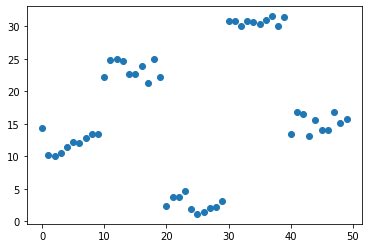

In [5]:
plt.scatter(x,y);

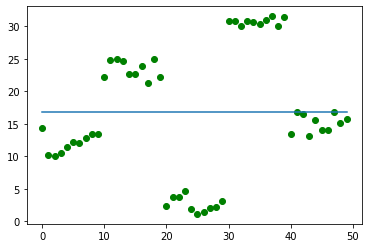

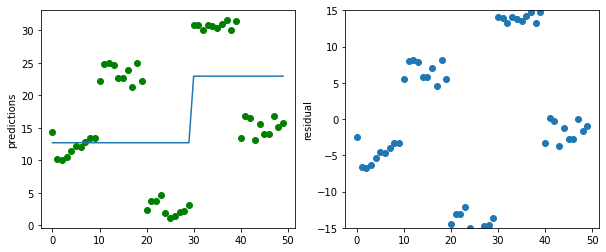

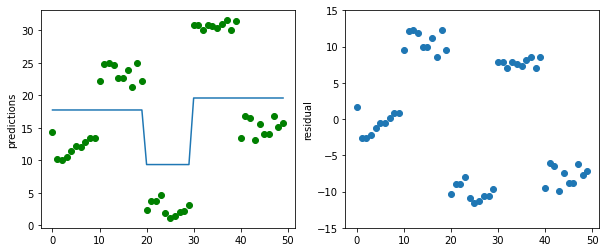

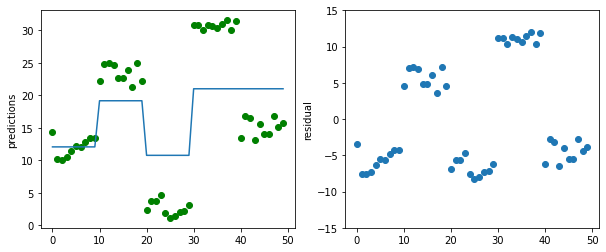

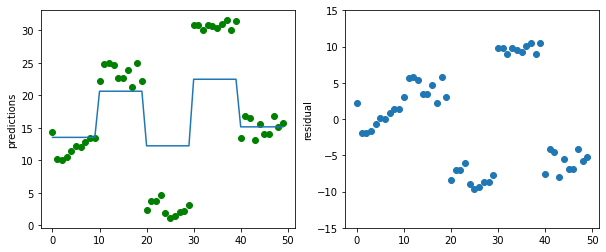

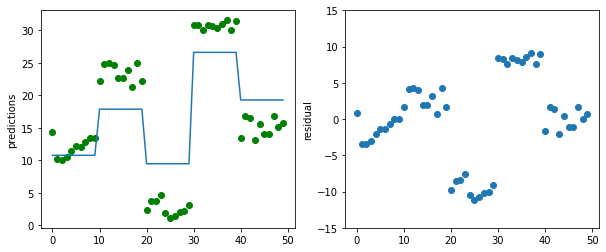

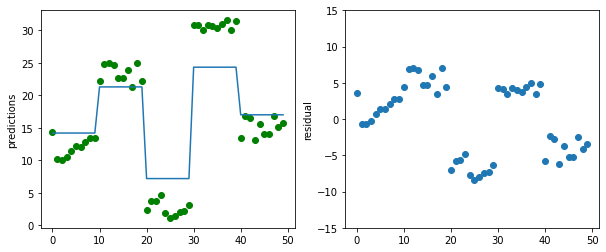

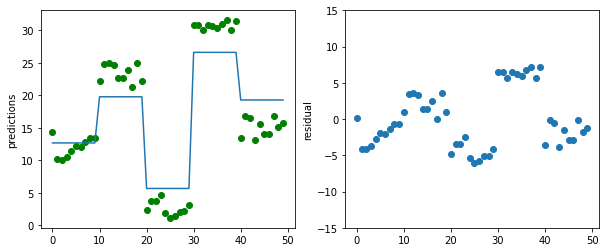

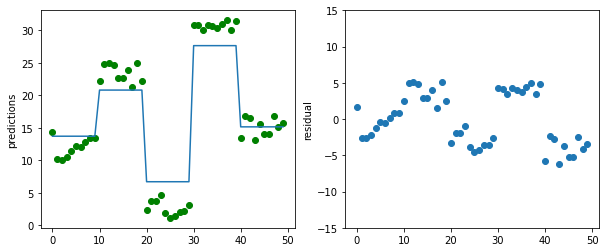

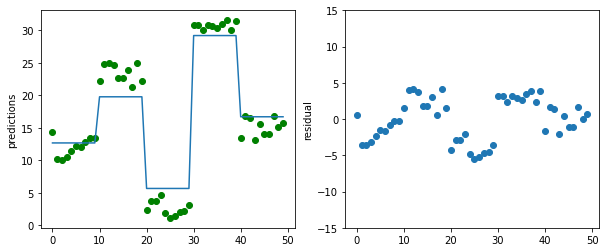

In [6]:
y_predicted1  = (np.ones(y.shape[0])*y.mean()).reshape(-1,1)
plt.scatter(x,y, c='green')
plt.plot(x,y_predicted1)
plt.show()

for n in range(1,10):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    e1 = y - y_predicted1
    axs[1].scatter(x,e1)
    axs[1].set_ylabel('residual')
    axs[1].set_ylim(-15,15)

    regressor = DecisionTreeRegressor(max_depth=1)
    regressor.fit(x,e1)
    e1_predicted = regressor.predict(x).reshape(-1,1)
    y_predicted2 = y_predicted1 + e1_predicted
    y_predicted1= y_predicted2
    axs[0].scatter(x,y, c='green')
    axs[0].plot(x,y_predicted2)
    axs[0].set_ylabel('predictions')


In [212]:
def plot_residuos(x, y, f_m, residuo):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[1].scatter(x,residuo)
    axs[1].set_ylabel('residual')
    axs[1].set_ylim(-15,15)
    
    axs[0].scatter(x,y, c='green')
    axs[0].scatter(x,f_m, c='blue', s=80, alpha=0.2)
    axs[0].set_ylabel('predictions')

In [111]:
10%3

1

In [241]:
y_train['target'] = 5
y_train

,target
46,5
47,5
15,5
9,5
16,5
24,5
34,5
31,5
0,5
44,5


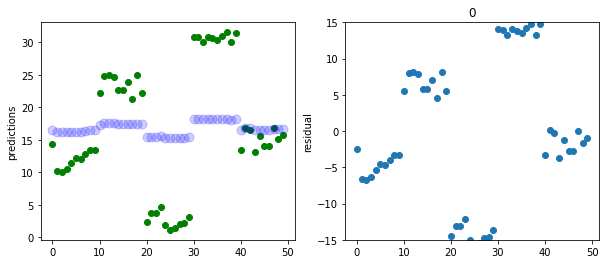

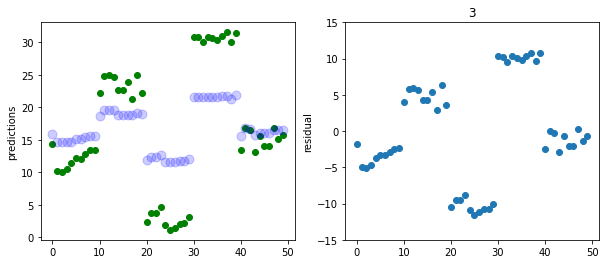

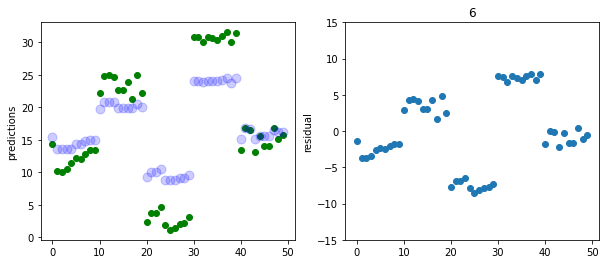

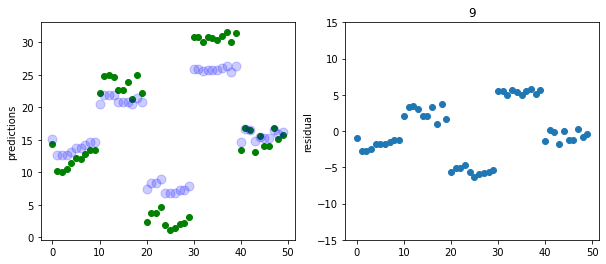

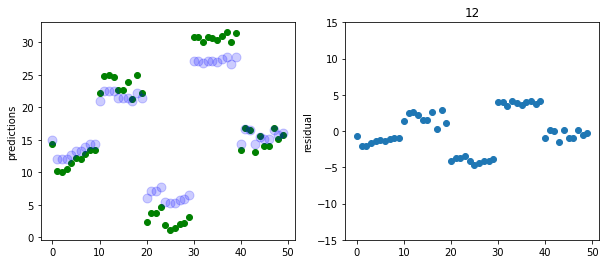

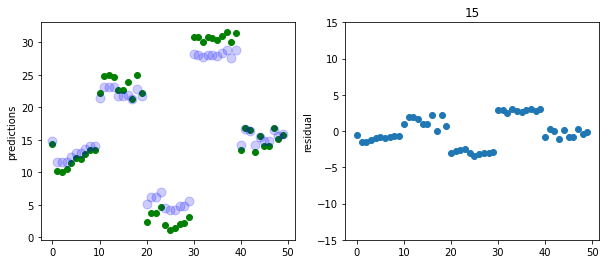

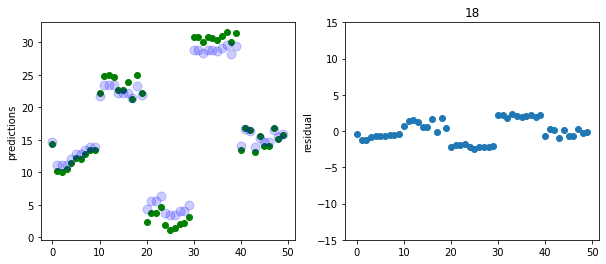

In [245]:
def to_df(array, column_name='target'):
    return pd.DataFrame(array, columns = [column_name])

class MyGBoost_Regressor():
    
    def __init__(self,n_estimators=10, max_depth= 5, learning_rate = 0.1):
        self.n_estimators=n_estimators
        self.max_depth=max_depth
        self.learning_rate=learning_rate
        
    # fit do modelo
    def fit(self, X, y):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.dataset = pd.concat([X,y], axis=1, ignore_index=True).rename({0:'target'})
        
        self.train()
    
    def train(self):
        
        self.ensemble = {}
        
        for m in range(self.n_estimators):
            
            base_tree = DecisionTreeRegressor(max_depth = self.max_depth)
            
            if (m==0):
                F_m_1 = to_df(self.y.mean().values*np.ones(self.y.shape[0]).reshape(-1,1))
#                 F_m_1 = self.y.mean().values[0]
                self.F_0 = F_m_1
                
            # delta_m (o residuo)
            delta_m = self.y - F_m_1

            base_tree.fit(self.X,delta_m)
            
            self.ensemble[m] = base_tree
            
            # F_m = F_m-1 + alpha * delta_m
            F_m = F_m_1 + self.learning_rate*to_df(base_tree.predict(self.X))
            
            F_m_1 = F_m
            
            if m%3==0:
                plot_residuos(self.X, self.y, F_m,delta_m)
                plt.title(m)
                
            
        return F_m
    
    
    def predict(self, X_pred):
        
        X_pred.reset_index(drop=True, inplace=True)
        
        for m in range(self.n_estimators):
            if(m==0): 
                F_m_1 = self.F_0

            F_m = F_m_1 + self.learning_rate*to_df(self.ensemble[m].predict(X_pred))
            
            F_m_1 = F_m
            
        return F_m

y_df = pd.DataFrame(y, columns=['target'])

    
regressor = MyGBoost_Regressor(n_estimators=20, max_depth= 5, learning_rate = 0.1)
regressor.fit(x,y_df)
# y_pred = regressor.train()
    

In [248]:
X_train, X_test, y_train, y_test= train_test_split(x,
                                                   to_df(y),
                                                   test_size=1/3, 
                                                   random_state=42)

print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))

X_train shape:(33, 1)
y_train shape:(33, 1)
X_test shape:(17, 1)
y_test shape:(17, 1)


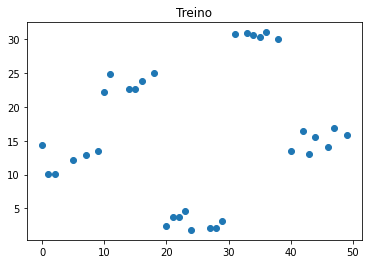

In [249]:
plt.scatter(X_train,y_train);
plt.title('Treino');

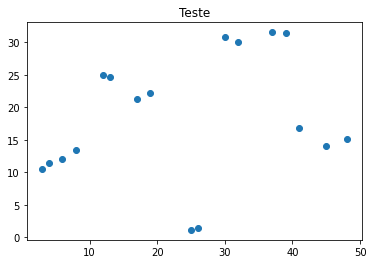

In [250]:
plt.scatter(X_test,y_test);
plt.title('Teste');

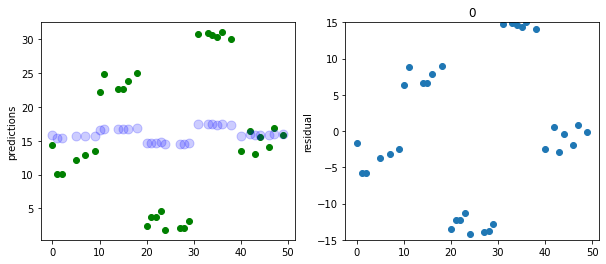

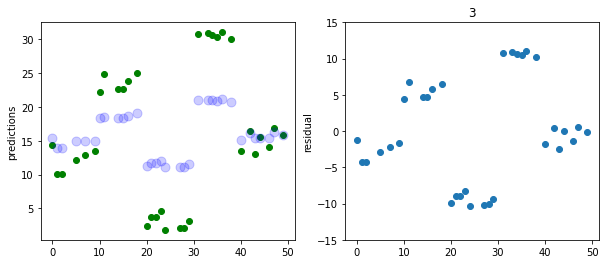

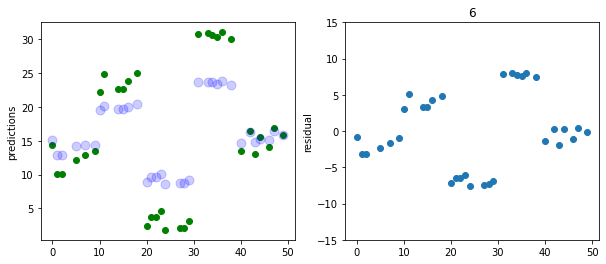

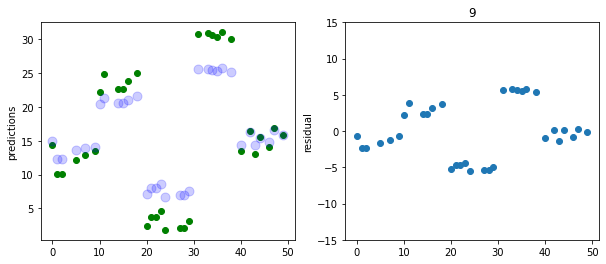

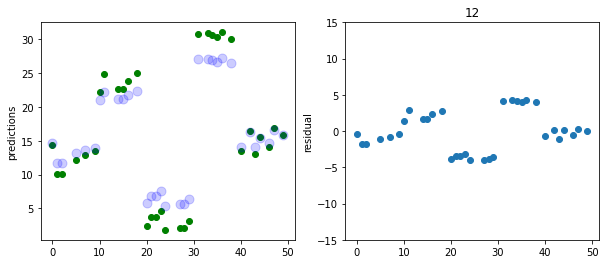

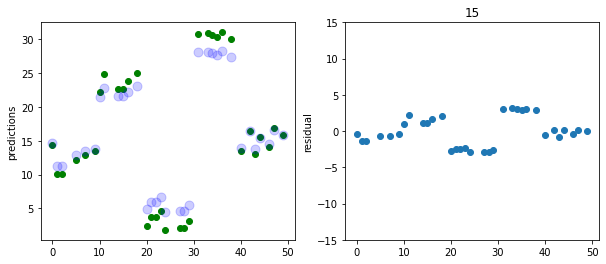

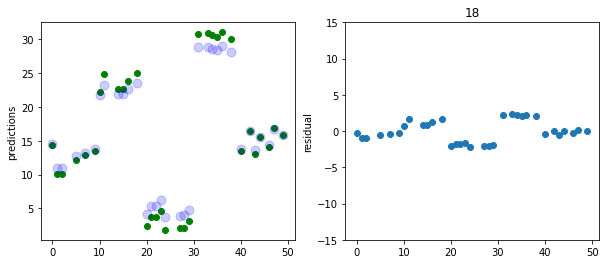

In [251]:
regressor = MyGBoost_Regressor(n_estimators=20, max_depth= 5, learning_rate = 0.1)
regressor.fit(X_train,y_train)

In [252]:
regressor.ensemble

{0: DecisionTreeRegressor(max_depth=5),
 1: DecisionTreeRegressor(max_depth=5),
 2: DecisionTreeRegressor(max_depth=5),
 3: DecisionTreeRegressor(max_depth=5),
 4: DecisionTreeRegressor(max_depth=5),
 5: DecisionTreeRegressor(max_depth=5),
 6: DecisionTreeRegressor(max_depth=5),
 7: DecisionTreeRegressor(max_depth=5),
 8: DecisionTreeRegressor(max_depth=5),
 9: DecisionTreeRegressor(max_depth=5),
 10: DecisionTreeRegressor(max_depth=5),
 11: DecisionTreeRegressor(max_depth=5),
 12: DecisionTreeRegressor(max_depth=5),
 13: DecisionTreeRegressor(max_depth=5),
 14: DecisionTreeRegressor(max_depth=5),
 15: DecisionTreeRegressor(max_depth=5),
 16: DecisionTreeRegressor(max_depth=5),
 17: DecisionTreeRegressor(max_depth=5),
 18: DecisionTreeRegressor(max_depth=5),
 19: DecisionTreeRegressor(max_depth=5)}

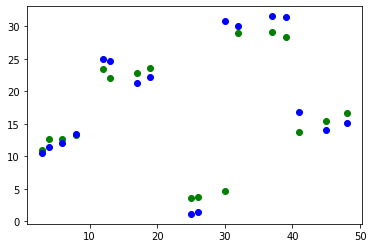

In [253]:
plt.scatter(X_test, regressor.predict(X_test).dropna().values, c='green')
plt.scatter(X_test,y_test.values, c='blue')


# Case 1 - Boston Dataset (Regressão)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.datasets import load_boston

import os, sys

sys.path.append(r'..\functions')
import model_functions, EDA

In [16]:
load_df = load_boston()
dataset = pd.concat([pd.DataFrame(load_df.data,columns = load_df.feature_names)
                     ,pd.DataFrame(load_df.target,columns = ['target'])], axis=1)

X_train, X_test, y_train, y_test= train_test_split(dataset.drop(columns = 'target'),
                                                   dataset['target'],
                                                   test_size=1/3, 
                                                   random_state=42)

print('X_train shape:{}'.format(X_train.shape))
print('y_train shape:{}'.format(y_train.shape))
print('X_test shape:{}'.format(X_test.shape))
print('y_test shape:{}'.format(y_test.shape))

X_train shape:(337, 13)
y_train shape:(337,)
X_test shape:(169, 13)
y_test shape:(169,)


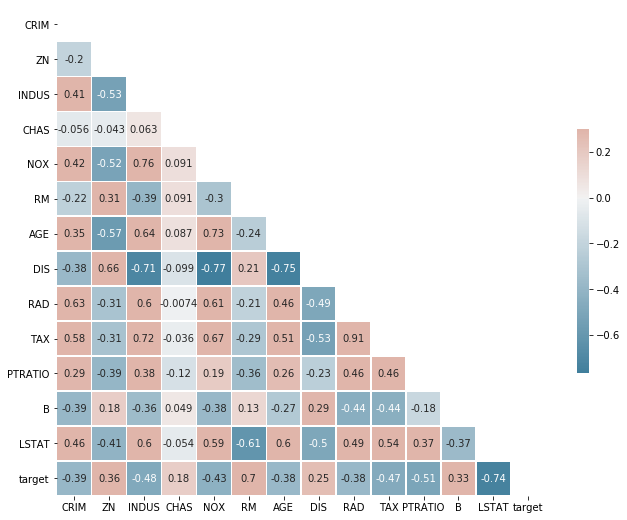

In [19]:
EDA.print_correlation_matrix(dataset, annot=True)

In [27]:
regressor = GradientBoostingRegressor()
regressor.fit(dataset.drop(columns='target'),dataset['target'])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
regressor.train_score_

array([71.3023975 , 60.62430365, 51.66940168, 44.36574755, 38.28309813,
       33.28631462, 28.91900173, 25.29674293, 22.25874685, 19.69227985,
       17.60439167, 15.76846604, 14.24440183, 13.00571507, 11.89029371,
       10.92253042, 10.11617186,  9.42909657,  8.82546741,  8.31191187,
        7.84854129,  7.42743188,  7.08602145,  6.75613848,  6.4696677 ,
        6.23114583,  6.00358034,  5.81282753,  5.62650044,  5.47626048,
        5.2897465 ,  5.14607051,  5.00172065,  4.87591695,  4.76109054,
        4.61022896,  4.49175256,  4.3951362 ,  4.24578878,  4.19058233,
        4.13158886,  4.04010276,  3.93237901,  3.86903444,  3.78680625,
        3.70641677,  3.66818582,  3.57506067,  3.51138687,  3.46630859,
        3.42385841,  3.39434619,  3.33554189,  3.27675695,  3.23012458,
        3.18896847,  3.14868534,  3.12136176,  3.07449852,  3.04371473,
        2.99464596,  2.95993898,  2.93356082,  2.9069982 ,  2.83929109,
        2.79136181,  2.75320178,  2.72795333,  2.70760939,  2.67

Text(0, 0.5, 'loss')

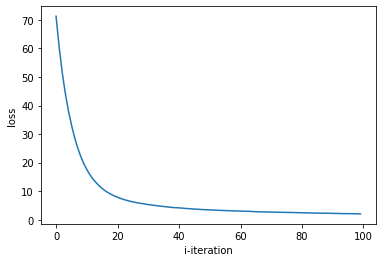

In [28]:
# The i-th score train_score_[i] is the deviance (= loss) of the model at iteration i on the in-bag sample. 
# If subsample == 1 this is the deviance on the training data.

# Ou seja, o train_score é o custo (MSE) de cada uma das arvores no treino - nota-se que ele se aproxima de zero ao final e 
# inicia grande - o que mostra a diminuição da função custo

plt.plot(regressor.train_score_)
plt.xlabel('i-iteration')
plt.ylabel('loss')

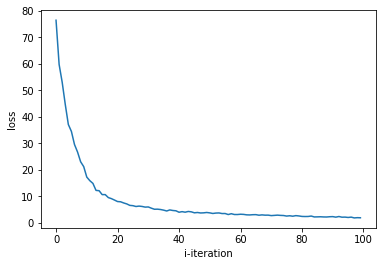

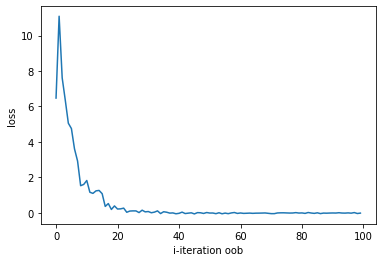

In [30]:
regressor = GradientBoostingRegressor(subsample=0.8)
regressor.fit(dataset.drop(columns='target'),dataset['target'])

plt.plot(regressor.train_score_)
plt.xlabel('i-iteration')
plt.ylabel('loss')
plt.show()

plt.plot(regressor.oob_improvement_)
plt.xlabel('i-iteration oob')
plt.ylabel('loss')
plt.show()

In [76]:
sample_i_stg_pred={}

for i in range(0,regressor.get_params()['n_estimators']):
    sample_i_stg_pred[i] = [x[i] for x in regressor.staged_predict(X_train)]


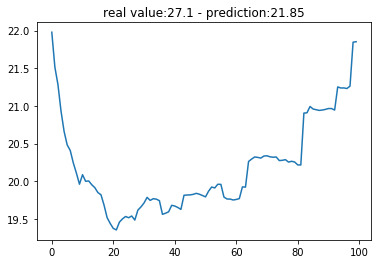

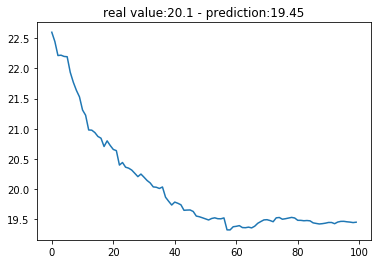

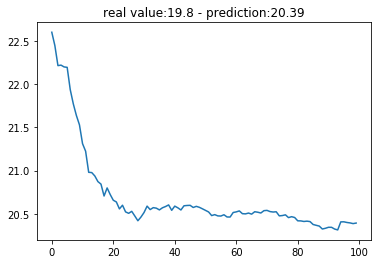

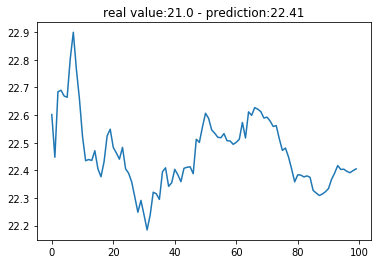

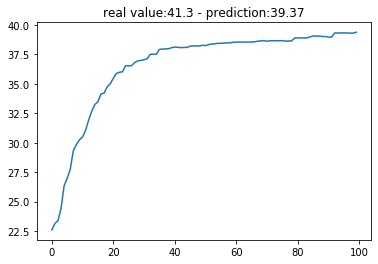

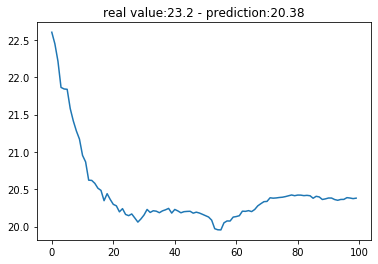

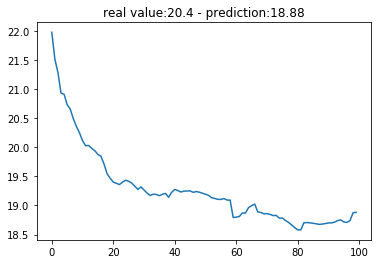

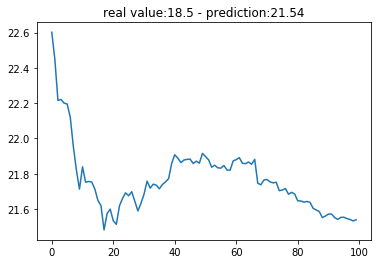

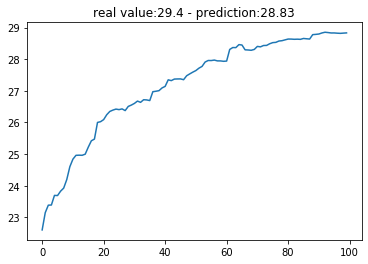

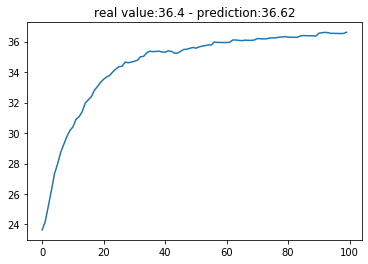

In [78]:
for i in range(0,10):
    plt.plot(sample_i_stg_pred[i])
    plt.title('real value:{} - prediction:{}'.format(y_train.iloc[i], round(sample_i_stg_pred[i][-1],2)))
    plt.show()


In [41]:
X_train.shape

(337, 13)

In [ ]:
regressor.staged_predict(X_train)

# Gradient Boosting para Classificação

In [258]:
def to_probs(logodds):
    return (np.exp(logodds))/(1 + np.exp(logodds))

def to_odds(p, log=True):
    odds=p/(1-p)
    
    if log:
        return np.log(odds)
    return odds



In [279]:
5/9

to_odds(5/9)

0.22314355131420993

In [260]:
to_odds(0.8581)

2.1972245773362196

In [275]:
to_probs(to_odds(0.6) + to_odds(0.6)+to_odds(0.6))

0.7714285714285715

In [282]:
data = pd.read_csv('data-2eb8o.csv')

In [326]:
data

,Wind Gust Speed,Humidity 3pm,"Rain Tomorrow Flag (1=Yes, 0=No)",Initial Prediction,Residuals
Obs,,,,,
1,26,59,1,0.56,0.44
2,46,54,1,0.56,0.44
3,48,84,1,0.56,0.44
4,48,58,1,0.56,0.44
5,15,80,1,0.56,0.44
6,39,4,0,0.56,-0.56
7,50,60,0,0.56,-0.56
8,40,37,0,0.56,-0.56
9,26,57,0,0.56,-0.56


In [284]:
data.set_index('Obs', inplace=True)

In [290]:
X = data.iloc[:,:3].copy()

In [293]:
X['initial_pred'] = X.iloc[:,-1].mean()

In [295]:
X['residuo'] = X.iloc[:,-2] - X['initial_pred']

In [299]:
tree = DecisionTreeRegressor(max_depth=1)

tree.fit(X.iloc[:,:2],X['residuo'])



DecisionTreeRegressor(max_depth=1)

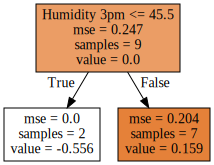

In [302]:
from sklearn.tree import export_graphviz
import graphviz

def plot_tree(classifier,X,y):
    regressor= DecisionTreeRegressor(max_depth=1)
    regressor.fit(X, y)
    y_pred = regressor.predict(X)

    export_graphviz(regressor, feature_names = X.columns, out_file='tree.dot',impurity=True, filled=True)

    with open('tree.dot') as f:
        dot_graph=f.read()
    display(graphviz.Source(dot_graph))
    
plot_tree(regressor,X.iloc[:,:2],X['residuo'])

Text(0, 0.5, 'residuo')

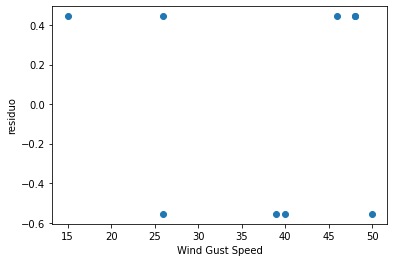

In [313]:
plt.scatter(X.iloc[:,0], X['residuo'])
plt.xlabel(X.iloc[:,0].name)
plt.ylabel('residuo')

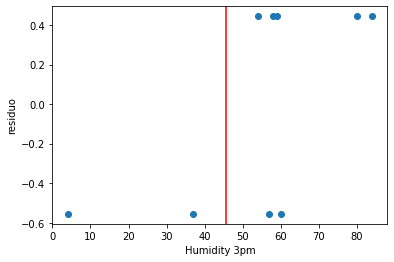

In [315]:
plt.scatter(X.iloc[:,1], X['residuo'])
plt.xlabel(X.iloc[:,1].name)
plt.ylabel('residuo')
plt.axvline(x=45.5, color='r', linestyle='-')

In [320]:
X[X.iloc[:,1]>45.5]['residuo'].mean()

0.15873015873015875

In [325]:
print('mse:{}'.format(sum((X[X.iloc[:,1]>45.5]['residuo'] - X[X.iloc[:,1]>45.5]['residuo'].mean())**2)/(X.iloc[:,1]>45.5).sum()))

mse:0.2040816326530612
